# Community detection

In [1]:
import warnings
warnings.filterwarnings('ignore')

from copy import copy
from time import time
from scipy.sparse.linalg import eigs, eigsh
from sklearn.metrics import adjusted_mutual_info_score as ami
import matplotlib.pyplot as plt

from src.CD import *

## Louvain algorithm

The Louvain algorithm is a greedy strategy to optimize the modularity on networks in order to find a community structure. The modularity is defined as

$$
\mathscr{Q}_A^{\rm Mod}(\mathbf{\ell}) = \frac{1}{2|\mathcal{E}|}\sum_{i,j\in\mathcal{V}}\left(A_{ij} - \frac{d_id_j}{2|\mathcal{E}}\right)\delta(\ell_i,\ell_j).
$$

This method does not require any prior knowledge of the input graph and it also outputs the number of communities. In many cases, however, the inferred node partition correspond to one of the many local minima of the modularity cost function: these local minima are many, hardly distinguishable in terms of modularity and uncorrelated with one-another. Moreover, the Louvain algorithm can find high modularity partitions also in completely random networks: keep this in mind when you are using it! 


### Modularity maximization on a random graph

In [2]:
import sknetwork as skn

In [3]:
n = 30000   # number of nodes
c = 5     # expected average degree

A = ErdosRenyi(n, c)

t0 = time()
louvain = skn.clustering.Louvain()
label = louvain.fit_predict(A)
k = len(np.unique(label))
print(f'Computation time: {time() - t0}')
print(f'Estimated number of classes = {k}')
print(f'Modularity = {ComputeModularity(A, label)}')

Computation time: 0.23760414123535156
Estimated number of classes = 232
Modularity = 0.43279801045920524


Note that we achieve a very large modularity value with a large number of communities on a completely random network. As an exercise, see how the results change tuning the value of `c`. We now also test different runs of the algorithm on the **same** graph and measure the similarity between the partitions in terms od *adjusted mutual information*.


In [4]:
labels, ami_score, mod_values = [], [], []
n_runs = 100 # number of runs of modularity maximization

print('Computing the partitions')
for t in range(n_runs):
    print("Progress: [%-25s] %d%%" % ('='*(int((t+1)  /n_runs*25)-1) + '>', (t+1)/(n_runs)*100), end = '\r')
    louvain = skn.clustering.Louvain(shuffle_nodes = True) 
    labels.append(louvain.fit_predict(A))
    mod_values.append(ComputeModularity(A, labels[-1]))

# sample 100 random pairs
idx1, idx2 = np.random.choice(np.arange(n_runs), (100,2)).T

print('\n Comparing the partitions')
for counter, (i, j) in enumerate(zip(idx1, idx2)):
    print("Progress: [%-25s] %d%%" % ('='*(int((counter+1)  /len(idx1)*25)-1) + '>', (counter+1)/(len(idx1))*100), end = '\r')
    if i != j:
        ami_score.append(ami(labels[i], labels[j]))

Computing the partitions
Progress: [========================>] 100%
 Comparing the partitions


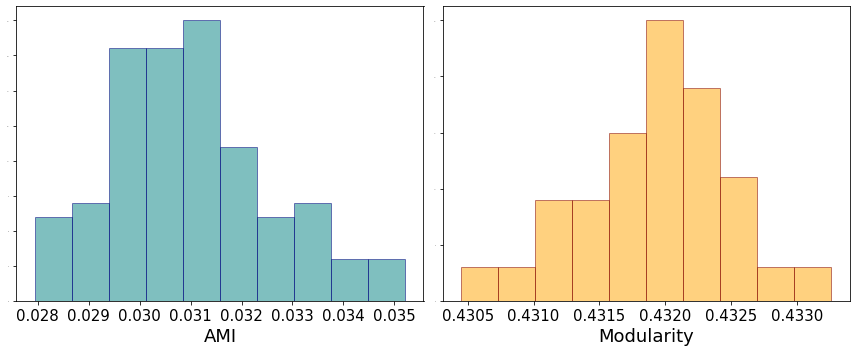

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))

ax[0].hist(ami_score, color = 'teal', edgecolor = 'navy', alpha = 0.5)
ax[0].set_xlabel('AMI', fontsize = 18)
ax[0].tick_params(axis='x', which='major', labelsize=15)
ax[0].tick_params(axis='y', which='major', labelsize=0)

ax[1].hist(mod_values, color = 'orange', edgecolor = 'maroon', alpha = 0.5)
ax[1].set_xlabel('Modularity', fontsize = 18)
ax[1].tick_params(axis='x', which='major', labelsize=15)
ax[1].tick_params(axis='y', which='major', labelsize=0)

plt.tight_layout()
plt.show();

## Modularity maximization on a graph with communities

In the previous section we considered a corner case in which there was absolutely no structure in the graph. The limitations associated with Louvain, however, are still observed in the presence of a community structure but are alleviated as the communities are more and more apart. We generate a graph from the *Stochastic block model* with $k=2$ communities so that

$$
\mathbb{P}(A_{ij}=1) = \begin{cases} \frac{c_{\rm in}}{n} \quad{\rm if~} \ell_i = \ell_j \\
                                    \frac{c_{\rm out}}{n} \quad{\rm else}
                        \end{cases}
$$

> **EXERCISE**: see how the result varies in terms of estimated number of communities, ami score and modularity by changing the ratio $\Gamma = c_{\rm in}/c_{\rm out}$.

In [6]:
k = 2                            # number of communities
n = 30000   
α = 2                            # ratio c_in/c_out (the larger is alpha, the simpler the problem)
c = 10                           # expected average degree
c_in, c_out = 2*c*α/(1+α), 2*c/(1+α)  # connections parameters
C = np.ones((k,k))*c_out + np.diag(np.ones(k))*(c_in - c_out) 
c = (c_in + (k-1)*c_out)/k 
print(f'α = {(c - c_out)/np.sqrt(c)}')

label_gt = np.ones(n)
label_gt[:int(n/2)] = 0
label_gt = label_gt.astype(int) # label vector
A, label = DCSBM(C,c, label_gt, np.ones(n))

t0 = time()
louvain = skn.clustering.Louvain()
label = louvain.fit_predict(A)
k = len(np.unique(label))
print(f'Computation time: {time() - t0}')
print(f'Estimated number of classes = {k}')
print(f'Modularity = {ComputeModularity(A, label)}')
print(f'AMI with ground truth partition', {ami(label, label_gt)})

α = 1.0540925533894596
Computation time: 0.4412708282470703
Estimated number of classes = 29
Modularity = 0.25974982716260403
AMI with ground truth partition {0.0004586513137530541}


## Bayesian inference

In the Bayesian framework, we consider community detection as an inference problem in which the labels have to be estimated from the adjacency matrix, which is a realization of a random variable.

$$
\mathbb{P}(\mathbf{\ell}|A) \propto \mathbb{P}(A|\mathbf{\ell})
$$

A first method is to maximize the the posterior distribution, or, equivalently, minimize the description length. Here we pick a smaller value of $n$ because these algorithms are slower.

In [7]:
from graph_tool import *
import graph_tool.all as gt

In [8]:
k = 2                            # number of communities
n = 3000   
Γ = 4                            # ratio c_in/c_out (the larger is alpha, the simpler the problem)
c = 10                           # expected average degree
c_in, c_out = 2*c*Γ/(1+Γ), 2*c/(1+Γ)  # connections parameters
C = np.ones((k,k))*c_out + np.diag(np.ones(k))*(c_in - c_out) 
c = (c_in + (k-1)*c_out)/k 
print(f'α = {(c - c_out)/np.sqrt(c)}')

label_gt = np.ones(n)
label_gt[:int(n/2)] = 0
label_gt = label_gt.astype(int) # label vector
A, label = DCSBM(C,c, label_gt, np.ones(n))

α = 1.8973665961010275


In [9]:
g = gt.Graph(directed=False)
g.add_edge_list(np.transpose(A.nonzero()))
t0 = time()
state = gt.minimize_blockmodel_dl(g, multilevel_mcmc_args=dict(B_max = 10))
label = np.array([state.get_blocks()[i] for i in range(n)])
print(f'Computation time: {time() - t0}')
print(f'Modularity = {ComputeModularity(A, label)}')
print(f'AMI with ground truth partition', {ami(label, label_gt)})

Computation time: 10.817868947982788
Modularity = 0.2777623274533254
AMI with ground truth partition {0.33976044084635443}


Instead of maximizing the posterior, we can sample from it. It takes longer, but it also potentially gives access to estimating the full marginals.

In [10]:
n_iter = 1000
t0 = time()

for i in range(n_iter): # this should be sufficiently large
    print("Progress: [%-25s] %d%%" % ('='*(int((i+1)/n_iter*25)-1) + '>', (i+1)/n_iter*100), end = '\r')
    state.gibbs_sweep(niter=10, allow_new_group = False)

label = np.array([state.get_blocks()[i] for i in range(n)])
print(f'Computation time: {time() - t0}')
print(f'Modularity = {ComputeModularity(A, label)}')
print(f'AMI with ground truth partition', {ami(label, label_gt)})

Computation time: 211.1382110118866>] 100%
Modularity = 0.16512517213321928
AMI with ground truth partition {0.3461689657279911}


## Spectral clustering


Here we will perform community detection using several spectral algorithms. We defined a function `SpectralClustering` that always takes the same form, to which we pass the matrix $M$ used to compute the eigenvectors, their position and the number of eigenvectors to be computed. Note that this function can only be deployed for Hermitian matrix of size $(n \times n)$. In the other  cases, the source code must be adapted.

### Graph Laplacian


The first method we consider is based upon the graph Laplacian $L = D-A$. In this case we compute the eigenvectors associated with the smallest eigenvalues. We consider a sufficiently dense regime (see what happens in the case of sparse graphs). For simple problems (large $\Gamma$) we can correctly recover the classes, but decreasing it, the performance suddenly drops from a non-zero value to zero. Can you guess why?

In [5]:
k = 2                                   # number of communities
n = 5000                               # number of nodes
Γ = 4                                   # ratio c_in/c_out (the larger is alpha, the simpler the problem)
c = 9                                   # expected average degree
c_in, c_out = 2*c*Γ/(1+Γ), 2*c/(1+Γ)    # connections parameters
C = np.ones((k,k))*c_out + np.diag(np.ones(k))*(c_in - c_out) 
c = (c_in + (k-1)*c_out)/k 

θ = np.ones(n)

π_v = np.array([1/k for a in range(k)])
Π_v = (np.cumsum([x for x in π_v]))*n

label_gt, a = np.zeros(n), 0
for i in range(n):
    if i > Π_v[a]:
        a = a+1
        
    label_gt[i] = a

label_gt = label_gt.astype(int)
A, label_gt = DCSBM(C,c, label_gt, θ)
n, _ = A.shape

φ = np.mean(θ**2)
α = (c - c_out)*np.sqrt(φ/c)
print(f'α = {α}')

α = 1.8


In [12]:
d = A@np.ones(n)
D = diags(d)
L = D - A

t0 = time()
label = SpectralClustering(L, 'SA', k)
print(f'Computation time: {time() - t0}')
print(f'Modularity = {ComputeModularity(A, label)}')
print(f'AMI with ground truth partition', {ami(label, label_gt)})

Computation time: 0.25074052810668945
Modularity = 0.0
AMI with ground truth partition {2.3042919162882692e-07}


### Adjacency matrix

The adjacency matrix has a smoother transition, but it unable to reach the detectability threshold. To see this, set yourself in the sparse regime and change $\Gamma$ until $\alpha$ gets close to $1$.

In [13]:
t0 = time()
label = SpectralClustering(A, 'LA', k)
print(f'Computation time: {time() - t0}')
print(f'Modularity = {ComputeModularity(A, label)}')
print(f'AMI with ground truth partition', {ami(label, label_gt)})

Computation time: 0.4836158752441406
Modularity = 0.29069930135308497
AMI with ground truth partition {0.6578991958136041}


### Bethe-Hessian

This matrix is adapted for sparse graphs and it is capable of finding a non-trivial community structure as soon as theoretically possible. Compare the performance of this algorithm against the other two for different values of $\Gamma$.

In [6]:
D = diags(A@np.ones(n))
Id = diags(np.ones(n))
Bp = BuildBp(A)
ρ_, _ = eigs(Bp, k = 1, which = 'LM')
ρ = ρ_[0].real
r = np.sqrt(ρ)
H = (r**2-1)*Id + D - r*A

t0 = time()
label = SpectralClustering(H, 'SA', k)
print(f'Computation time: {time() - t0}')
print(f'Modularity = {ComputeModularity(A, label)}')
print(f'AMI with ground truth partition', {ami(label, label_gt)})

Computation time: 0.21099376678466797
Modularity = 0.2989031666155732
AMI with ground truth partition {0.6882953248394101}


## Belief propagation

Recalling that the Bayes optimal solution can be approximated with belief propagation (cavity method), we now see how to deploy it. To speed up the convergence, we initialize it to the result obtained with spectral clustering.

In [15]:
g = gt.Graph(directed=False)
g.add_edge_list(np.transpose(A.nonzero()))

t0 = time()
state = gt.EMBlockState(g, B = k, init_state = gt.BlockState(g, label))
delta, niter = gt.em_infer(state)
label_BP = np.array([np.argmax(state.get_vertex_marginals()[i]) for i in range(n)])
print(f'Computation time: {time() - t0}')
print(f'Modularity = {ComputeModularity(A, label_BP)}')
print(f'AMI with ground truth partition', {ami(label_BP, label_gt)})

Computation time: 5.10416579246521
Modularity = 0.3040515239067221
AMI with ground truth partition {0.7618251296221443}


## Estimate $k$ with the Bethe-Hessian

In [8]:
γ, _ = eigsh(H, k = 50, which = 'SA')
kest = np.sum(γ < 0)
print(f'Estimated number of communities = {kest}')
print(f'Number of communities = {k}')

Estimated number of communities = 2
Number of communities = 2
